#**Carcinogenic Chemical Releases**

_______________________________________________________

###With the data retrieved from https://enviro.epa.gov/facts/tri/form_ra_download.html? I will predict carcinogenic toxic releases worldwide.

#Install Needed Packages

In [1]:
    !pip install category_encoders==2.*
    !pip install pandas_profiling==2.*
    !pip install pdpbox
    !pip install shap

  Using cached matplotlib-3.5.0-cp37-cp37m-manylinux_2_5_x86_64.manylinux1_x86_64.whl (11.2 MB)
  Attempting uninstall: matplotlib
    Found existing installation: matplotlib 3.1.1
    Uninstalling matplotlib-3.1.1:
      Successfully uninstalled matplotlib-3.1.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
pdpbox 0.2.1 requires matplotlib==3.1.1, but you have matplotlib 3.5.0 which is incompatible.
albumentations 0.1.12 requires imgaug<0.2.7,>=0.2.5, but you have imgaug 0.2.9 which is incompatible.


  Using cached matplotlib-3.1.1-cp37-cp37m-manylinux1_x86_64.whl (13.1 MB)
  Attempting uninstall: matplotlib
    Found existing installation: matplotlib 3.5.0
    Uninstalling matplotlib-3.5.0:
      Successfully uninstalled matplotlib-3.5.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
pandas-profiling 2.13.0 requires matplotlib>=3.2.0, but you have matplotlib 3.1.1 which is incompatible.
albumentations 0.1.12 requires imgaug<0.2.7,>=0.2.5, but you have imgaug 0.2.9 which is incompatible.


#Import Necessary Modules

In [2]:
import category_encoders as ce
from category_encoders import OrdinalEncoder, OneHotEncoder
from pandas_profiling import ProfileReport
from pdpbox.pdp import pdp_isolate, pdp_plot
from scipy.stats import randint, uniform
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor, GradientBoostingClassifier
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, plot_confusion_matrix, classification_report
from sklearn.model_selection import train_test_split, RandomizedSearchCV,cross_val_score, validation_curve
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.utils import resample

import matplotlib.pyplot as plt
import missingno as msno
import numpy as np
import pandas as pd
import shap


/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


#Load Data

In [3]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [4]:
import os
os.environ['Toxics_Release'] = "/content/gdrive/MyDrive/Toxics_Release"

In [5]:
%cd /content/gdrive/MyDrive/Toxics_Release
!ls

/content/gdrive/MyDrive/Toxics_Release
Toxics_Release.csv


In [6]:
train = pd.read_csv('Toxics_Release.csv')
train

,V_TRI_FORM_R_EZ.ACTIVE_STATUS,V_TRI_FORM_R_EZ.ADJUSTED,V_TRI_FORM_R_EZ.AIR_TOTAL_RELEASE,V_TRI_FORM_R_EZ.ANCILLARY,V_TRI_FORM_R_EZ.ANCL_OTHER_USE_CLEANER,V_TRI_FORM_R_EZ.ANCL_OTHER_USE_CONSTRUCT_MATLS,V_TRI_FORM_R_EZ.ANCL_OTHER_USE_DEGREASER,V_TRI_FORM_R_EZ.ANCL_OTHER_USE_FLAME_RETARDANT,V_TRI_FORM_R_EZ.ANCL_OTHER_USE_FUEL,V_TRI_FORM_R_EZ.ANCL_OTHER_USE_LUBRICANT,V_TRI_FORM_R_EZ.ANCL_OTHER_USE_OTHER,V_TRI_FORM_R_EZ.ANCL_OTHER_USE_WASTE_TREAT,V_TRI_FORM_R_EZ.ANCL_OTHER_USE_WATER_TREAT,V_TRI_FORM_R_EZ.ARTICLE_COMPONENT,V_TRI_FORM_R_EZ.BYPRODUCT,V_TRI_FORM_R_EZ.CAAC_IND,V_TRI_FORM_R_EZ.CARC_IND,V_TRI_FORM_R_EZ.CAS_CHEM_NAME,V_TRI_FORM_R_EZ.CAS_REGISTRY_NUMBER,V_TRI_FORM_R_EZ.CHEM_NAME,V_TRI_FORM_R_EZ.CHEM_PROCESSING_AID,V_TRI_FORM_R_EZ.CHEM_PROCESS_AID_CATALYSTS,V_TRI_FORM_R_EZ.CHEM_PROCESS_AID_INHIBITORS,V_TRI_FORM_R_EZ.CHEM_PROCESS_AID_INITIATORS,V_TRI_FORM_R_EZ.CHEM_PROCESS_AID_OTHER,V_TRI_FORM_R_EZ.CHEM_PROCESS_AID_PROCESS_SOLVS,V_TRI_FORM_R_EZ.CHEM_PROCESS_AID_REACT_TERMIN,V_TRI_FORM_R_EZ.CHEM_PROCESS_AID_SOLUTION_BUF,V_TRI_FORM_R_EZ.CITY_NAME,V_TRI_FORM_R_EZ.COLLECT_DESC,V_TRI_FORM_R_EZ.CONVEYOR,V_TRI_FORM_R_EZ.COUNTY_NAME,V_TRI_FORM_R_EZ.COVERED_NAICS,V_TRI_FORM_R_EZ.DB_ADD_IND,V_TRI_FORM_R_EZ.DISP_LANDFILL_SURF_IMP,V_TRI_FORM_R_EZ.DISP_LAND_TREATMENT,V_TRI_FORM_R_EZ.DISP_OTHER_LAND_DISP,V_TRI_FORM_R_EZ.DISP_OTHER_OFFSITE_MGMT,V_TRI_FORM_R_EZ.DISP_SOLID_STAB,V_TRI_FORM_R_EZ.DISP_STORAGE_ONLY,...,V_TRI_FORM_R_EZ.OTH_DISP_TOT_REL,V_TRI_FORM_R_EZ.OTH_LANDF_RELEASE_NA,V_TRI_FORM_R_EZ.OTH_LANDF_TOT_REL,V_TRI_FORM_R_EZ.OTH_SURF_IMP_RELEASE_NA,V_TRI_FORM_R_EZ.OTH_SURF_IMP_TOT_REL,V_TRI_FORM_R_EZ.PARENT_CO_DB_NUM,V_TRI_FORM_R_EZ.PARENT_CO_NAME,V_TRI_FORM_R_EZ.PARTIAL_FAC,V_TRI_FORM_R_EZ.PFAS_IND,V_TRI_FORM_R_EZ.PRIMARY_NAICS_CODE,V_TRI_FORM_R_EZ.PRIMARY_SIC_CODE,V_TRI_FORM_R_EZ.PROCESSED_RECYCLING,V_TRI_FORM_R_EZ.PROCESS_IMPURITY,V_TRI_FORM_R_EZ.PRODUCE,V_TRI_FORM_R_EZ.PRODUCTION_RATIO,V_TRI_FORM_R_EZ.PRODUCTION_RATIO_NA,V_TRI_FORM_R_EZ.PROD_RATIO_OR_ACTIVITY,V_TRI_FORM_R_EZ.PUBLIC_CONTACT_PERSON,V_TRI_FORM_R_EZ.PUBLIC_CONTACT_PHONE,V_TRI_FORM_R_EZ.REACTANT,V_TRI_FORM_R_EZ.REACTANT_FEEDSTOCKS,V_TRI_FORM_R_EZ.REACTANT_INITIATORS,V_TRI_FORM_R_EZ.REACTANT_INTERMEDIATES,V_TRI_FORM_R_EZ.REACTANT_OTHER,V_TRI_FORM_R_EZ.REACTANT_RAW_MATERIALS,V_TRI_FORM_R_EZ.RECYC_OFFSITE_CURR_YR_QTY,V_TRI_FORM_R_EZ.RECYC_ONSITE_CURR_YR_QTY,V_TRI_FORM_R_EZ.REGION,V_TRI_FORM_R_EZ.REPORTING_YEAR,V_TRI_FORM_R_EZ.SALE_DISTRIBUTION,V_TRI_FORM_R_EZ.SOURCE,V_TRI_FORM_R_EZ.STANDARDIZED_PARENT_COMPANY,V_TRI_FORM_R_EZ.STORM_WATER_PERCENT_1,V_TRI_FORM_R_EZ.TOTAL_OFF_SITE_RELEASE,V_TRI_FORM_R_EZ.TOTAL_ON_OFF_SITE_RELEASE,V_TRI_FORM_R_EZ.TOTAL_ON_SITE_RELEASE,V_TRI_FORM_R_EZ.TOTAL_PRODUCTION_RELATED_WASTE,V_TRI_FORM_R_EZ.TREATED_ONSITE_CURR_YR_QTY,V_TRI_FORM_R_EZ.TREATED_ONSITE_SECD_YR_NA,V_TRI_FORM_R_EZ.ZIP_CODE
0,1,NaN,0.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,1.0,Di(2-ethylhexyl) phthalate,117-81-7,Di(2-ethylhexyl) phthalate,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,EUFAULA,ADDRESS MATCHING-HOUSE NUMBER,FRS-TRIS,BARBOUR,1.0,0.0,0.000000,0.0,0.0,0.0,0.00,0.0,...,0.0,NaN,0.0,NaN,0.0,4006797,MANN'S BAIT CO,0.0,0.0,339920.0,3949,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.0,2004.0,NaN,ASSIGNED,NaN,NaN,0.000000,0.000000,0.00,0.000000e+00,NaN,NaN,36027.0
1,1,NaN,0.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,Copper,7440-50-8,Copper,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,GARDENA,ADDRESS MATCHING-HOUSE NUMBER,FRS-GEOCODE,LOS ANGELES,1.0,0.0,0.000000,0.0,0.0,0.0,0.00,0.0,...,0.0,NaN,0.0,NaN,0.0,608926952,L-3 COMMUNICATIONS,0.0,0.0,335311.0,3612,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,9.0,2003.0,NaN,ASSIGNED,NaN,NaN,0.000000,0.000000,0.00,0.000000e+00,NaN,NaN,90248.0
2,1,NaN,0.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,0.0,Methanol,67-56-1,Methanol,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,ATLANTA,INTERPOLATION-PHOTO,FRS-TRIS,FULTON,1.0,0.0,0.000000,0.0,0.0,0.0,0.00,0.0,...,0.0,NaN,0.0,NaN,0.0,40677957,NIAGARA NATI

In [7]:
corr = train.corr().sum()
(corr < 0).sort_values().tail(20)

V_TRI_FORM_R_EZ.ENERGY_ONSITE_CURR_YR_QTY         False
V_TRI_FORM_R_EZ.ENTIRE_FAC                        False
V_TRI_FORM_R_EZ.FAC_CLOSED_IND                    False
V_TRI_FORM_R_EZ.FEDS_IND                          False
V_TRI_FORM_R_EZ.FORMULATION_COMPONENT             False
V_TRI_FORM_R_EZ.FORMUL_COMP_ADDITIVES             False
V_TRI_FORM_R_EZ.FEDERAL_FAC_IND                   False
V_TRI_FORM_R_EZ.FORMUL_COMP_EMULSIFIERS           False
V_TRI_FORM_R_EZ.FORMUL_COMP_FLAME_RETARDANTS      False
V_TRI_FORM_R_EZ.FORMUL_COMP_INHIBITORS            False
V_TRI_FORM_R_EZ.FORMUL_COMP_DYES                  False
V_TRI_FORM_R_EZ.ZIP_CODE                          False
V_TRI_FORM_R_EZ.FUGITIVE_RELEASE_NA                True
V_TRI_FORM_R_EZ.CHEM_PROCESS_AID_PROCESS_SOLVS     True
V_TRI_FORM_R_EZ.FORMUL_COMP_SOLVENTS               True
V_TRI_FORM_R_EZ.METAL_IND                          True
V_TRI_FORM_R_EZ.EPA_REGISTRY_ID                    True
V_TRI_FORM_R_EZ.ANCILLARY                       

#Wrangle Data

In [8]:
def wrangle(df):

  # Drop HCCs
  threshold = 100
  drop_hcc = [col for col in df.select_dtypes('object').columns
              if df[col].nunique() > threshold]
  df.drop(columns=drop_hcc, inplace=True)

  #drop constant columns 
  constant_columns = [col for col in df.columns if df[col].nunique() ==1]
  df = df.drop(columns=constant_columns)

  #drop columns missing too much data
  isnull_columns = [col for col in df.columns if df[col].isnull().sum() >45000]
  df = df.drop(columns=isnull_columns)

  #drop string columns that do not help our model
  df = df.drop('V_TRI_FORM_R_EZ.COLLECT_DESC',1)
  df = df.drop('V_TRI_FORM_R_EZ.CONVEYOR',1)
  df = df.drop('V_TRI_FORM_R_EZ.SOURCE',1)
  df = df.drop('V_TRI_FORM_R_EZ.MAX_AMOUNT_OF_CHEM',1)
  
  #remove column prefix
  df.columns = df.columns.str.strip('V_TRI_FORM_R_EZ.')

  #drop columns suggesting negative correlations to model by Shapley evaluation
  #shap_drops = ['AL_PRODUCTION_RELATED_WAS', 'AL_ON_OFF_SITE_RELEAS', 'ACTAN', 'BYPRODUC']
  #df = df.drop(columns=shap_drops)

  #replace NaNs
  df = df.fillna(42) #Experimenting with NaNs being represented with number unique to other data

  return df

df = wrangle(train)

df.shape

(99943, 67)

In [9]:
df

,ACTIVE_STATUS,AIR_TOTAL_RELEAS,ANCILLARY,ARTICLE_COMPONEN,BYPRODUC,CAAC_IND,CARC_IND,CHEM_PROCESSING_AID,COVERED_NAICS,DB_ADD_IND,DISP_LANDFILL_SURF_IMP,DISP_LAND_TREATMEN,DISP_OTHER_LAND_DISP,DISP_OTHER_OFFSITE_MG,DISP_SOLID_STAB,DISP_STORAGE_ONLY,DISP_TRANS_WASTE_BROK,DISP_UNGRND_INJ,DISP_UNKNOWN,DISP_WASTEWATER_TREA,DOC_CTRL_NU,NERGY_ONSITE_CURR_YR_NA,NTIRE_FAC,PA_REGISTRY_ID,AC_CLOSED_IND,DERAL_FAC_IND,ULATION_COMPONEN,UGITIVE_RELEASE_NA,UGITIVE_TOT_REL,GOCO_FLAG,PORTED,NACTIVE_DA,LAND_TOTAL_RELEAS,LAND_TREA_RELEASE_NA,LAND_TREA_TOT_REL,LATITUD,LONGITUD,ANUFACTURE_AID,ANUFACTURE_IMPURITY,AL_IND,NPDES_ADD_IND,NE_TIME_RELEASE_QTY_NA,NS_EFFICIENCY_EST_NA_1,NS_WASTESTREAM_ADD_IND,H_DISP_RELEASE_NA,H_DISP_TOT_REL,H_LANDF_RELEASE_NA,H_LANDF_TOT_REL,H_SURF_IMP_RELEASE_NA,H_SURF_IMP_TOT_REL,PARTIAL_FAC,PFAS_IND,PRIMARY_NAICS_COD,PROCESS_IMPURITY,PRODUC,PRODUCTION_RA,PRODUCTION_RATIO_NA,ACTAN,GION,PORTING_YEA,SALE_DISTRIBUTION,AL_OFF_SITE_RELEAS,AL_ON_OFF_SITE_RELEAS,AL_ON_SITE_RELEAS,AL_PRODUCTION_RELATED_WAS,ATED_ONSITE_SECD_YR_NA,P_COD
0,1,0.00,42.0,42.0,42.0,1.0,1.0,42.0,1.0,0.0,0.000000,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,1.304200e+12,42.0,0.0,1.100000e+11,0.0,0.0,42.0,42.0,0.000,0.0,42.0,9999.0,0.0,42.0,0.0,31.858516,-85.149266,42.0,42.0,0.0,0.0,42.0,42.0,0.0,42.0,0.0,42.0,0.0,42.0,0.0,0.0,0.0,339920.0,42.0,42.0,42.00,42.0,42.0,4.0,2004.0,42.0,0.000000,0.000000,0.00,0.000000e+00,42.0,36027.0
1,1,0.00,42.0,42.0,42.0,0.0,0.0,42.0,1.0,0.0,0.000000,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,1.303200e+12,42.0,1.0,1.100000e+11,0.0,0.0,42.0,42.0,0.000,0.0,42.0,9999.0,0.0,42.0,0.0,33.854236,-118.287707,42.0,42.0,1.0,0.0,42.0,42.0,0.0,42.0,0.0,42.0,0.0,42.0,0.0,0.0,0.0,335311.0,42.0,42.0,42.00,42.0,42.0,9.0,2003.0,42.0,0.000000,0.000000,0.00,0.000000e+00,42.0,90248.0
2,1,0.00,42.0,42.0,42.0,1.0,0.0,42.0,1.0,0.0,0.000000,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,1.302200e+12,42.0,1.0,1.100090e+11,0.0,0.0,42.0,42.0,0.000,0.0,42.0,9999.0,0.0,42.0,0.0,33.817942,-84.433582,42.0,42.0,0.0,0.0,42.0,42.0,0.0,42.0,0.0,42.0,0.0,42.0,0.0,0.0,0.0,325611.0,42.0,42.0,42.00,42.0,42.0,4.0,2002.0,42.0,0.000000,0.000000,0.00,0.000000e+00,42.0,30318.0
3,1,0.00,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.000000,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,1.311210e+12,42.0,1.0,1.100000e+11,0.0,0.0,0.0,42.0,0.000,0.0,0.0,9999.0,0.0,42.0,0.0,41.109540,-81.379940,0.0,0.0,0.0,0.0,0.0,42.0,0.0,42.0,0.0,42.0,0.0,42.0,0.0,0.0,0.0,424690.0,0.0,0.0,42.00,0.0,0.0,5.0,2011.0,0.0,0.000000,0.000000,0.00,0.000000e+00,42.0,44240.0
4,1,0.00,42.0,42.0,42.0,1.0,1.0,42.0,1.0,0.0,0.000000,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,1.304200e+12,42.0,1.0,1.100410e+11,0.0,0.0,42.0,42.0,0.000,0.0,42.0,9999.0,0.0,42.0,0.0,39.766944,-75.421361,42.0,42.0,0.0,0.0,42.0,42.0,0.0,42.0,0.0,42.0,0.0,42.0,0.0,0.0,0.0,325211.0,42.0,42.0,42.00,42.0,42.0,2.0,2004.0,42.0,0.000000,0.000000,0.00,0.000000e+00,42.0,8067.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99938,1,145.00,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,39000.000000,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,1.302200e+12,1.0,1.0,1.100000e+11,0.0,0.0,0.0,0.0,5.000,0.0,0.0,9999.0,1105.0,1.0,0.0,42.272700,-83.112400,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,5.0,1.0,0.0,42.0,0.0,0.0,0.0,221112.0,1.0,1.0,1.31,0.0,0.0,5.0,2002.0,0.0,39000.000000,40250.000000,1250.00,4.000000e+04,1.0,48218.0
99939,1,924.00,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.000000,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,1.306200e+12,0.0,1.0,1.100010e+11,0.0,0.0,0.0,1.0,0.000,0.0,0.0,9999.0,0.0,1.0,0.0,39.477220,-79.066400,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,325191.0,0.0,1.0,0.83,0.0,0.0,3.0,2006.0,0.0,0.000000,924.000000,924.00,1.384222e+06,1.0,26726.0
99940,1,0.76,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.000000,0.0,0.0,0.0,0.01,0.0,0.0,0.0,0.0,0.0,1.303200e+12,1.0,1.0,1.100130e+11,0.0,0.0,

In [10]:
df['PORTING_YEA'].value_counts()

2001.0    5732
2002.0    5628
2005.0    5392
2003.0    5392
2006.0    5306
2004.0    5279
2007.0    5261
2008.0    5045
2013.0    4899
2014.0    4881
2012.0    4830
2009.0    4806
2015.0    4780
2016.0    4765
2018.0    4750
2011.0    4738
2017.0    4677
2019.0    4655
2010.0    4609
2020.0    4516
42.0         2
Name: PORTING_YEA, dtype: int64

In [11]:
#Report = ProfileReport(df, minimal=True).to_notebook_iframe()

##Data Exploration

In [12]:
df.info(
  
)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99943 entries, 0 to 99942
Data columns (total 67 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   ACTIVE_STATUS              99943 non-null  int64  
 1   AIR_TOTAL_RELEAS           99943 non-null  float64
 2   ANCILLARY                  99943 non-null  float64
 3   ARTICLE_COMPONEN           99943 non-null  float64
 4   BYPRODUC                   99943 non-null  float64
 5   CAAC_IND                   99943 non-null  float64
 6   CARC_IND                   99943 non-null  float64
 7   CHEM_PROCESSING_AID        99943 non-null  float64
 8   COVERED_NAICS              99943 non-null  float64
 9   DB_ADD_IND                 99943 non-null  float64
 10  DISP_LANDFILL_SURF_IMP     99943 non-null  float64
 11  DISP_LAND_TREATMEN         99943 non-null  float64
 12  DISP_OTHER_LAND_DISP       99943 non-null  float64
 13  DISP_OTHER_OFFSITE_MG      99943 non-null  flo

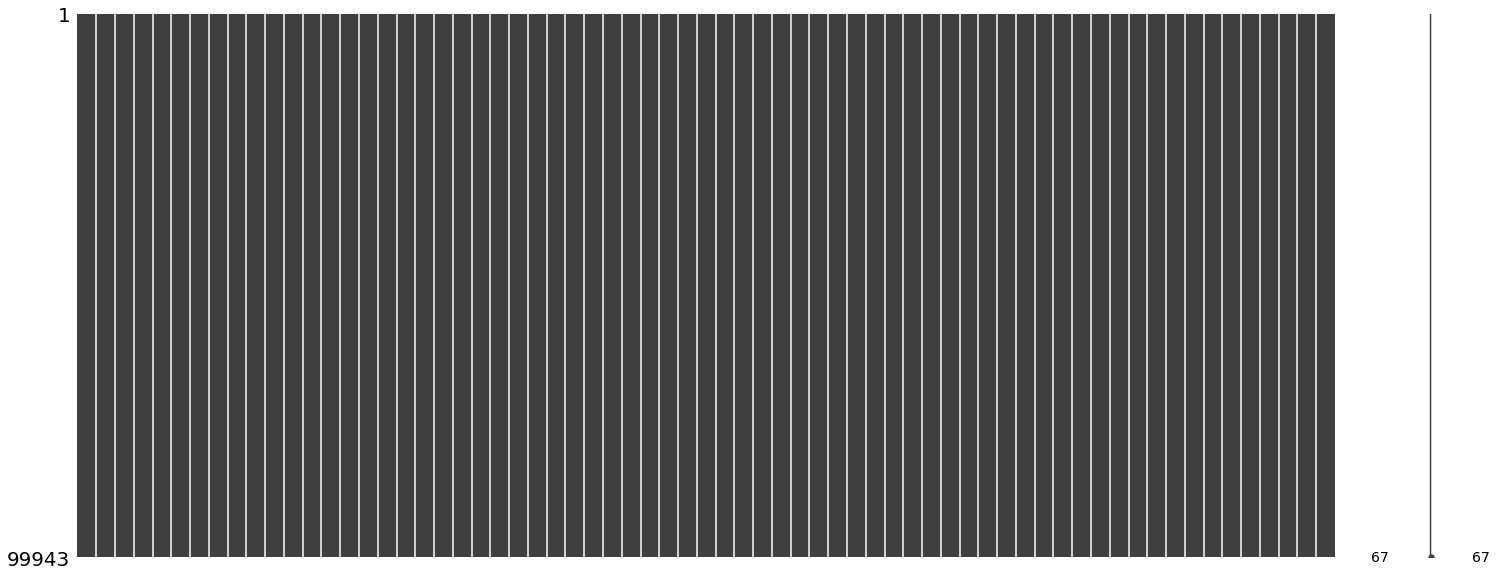

In [13]:
msno.matrix(df)

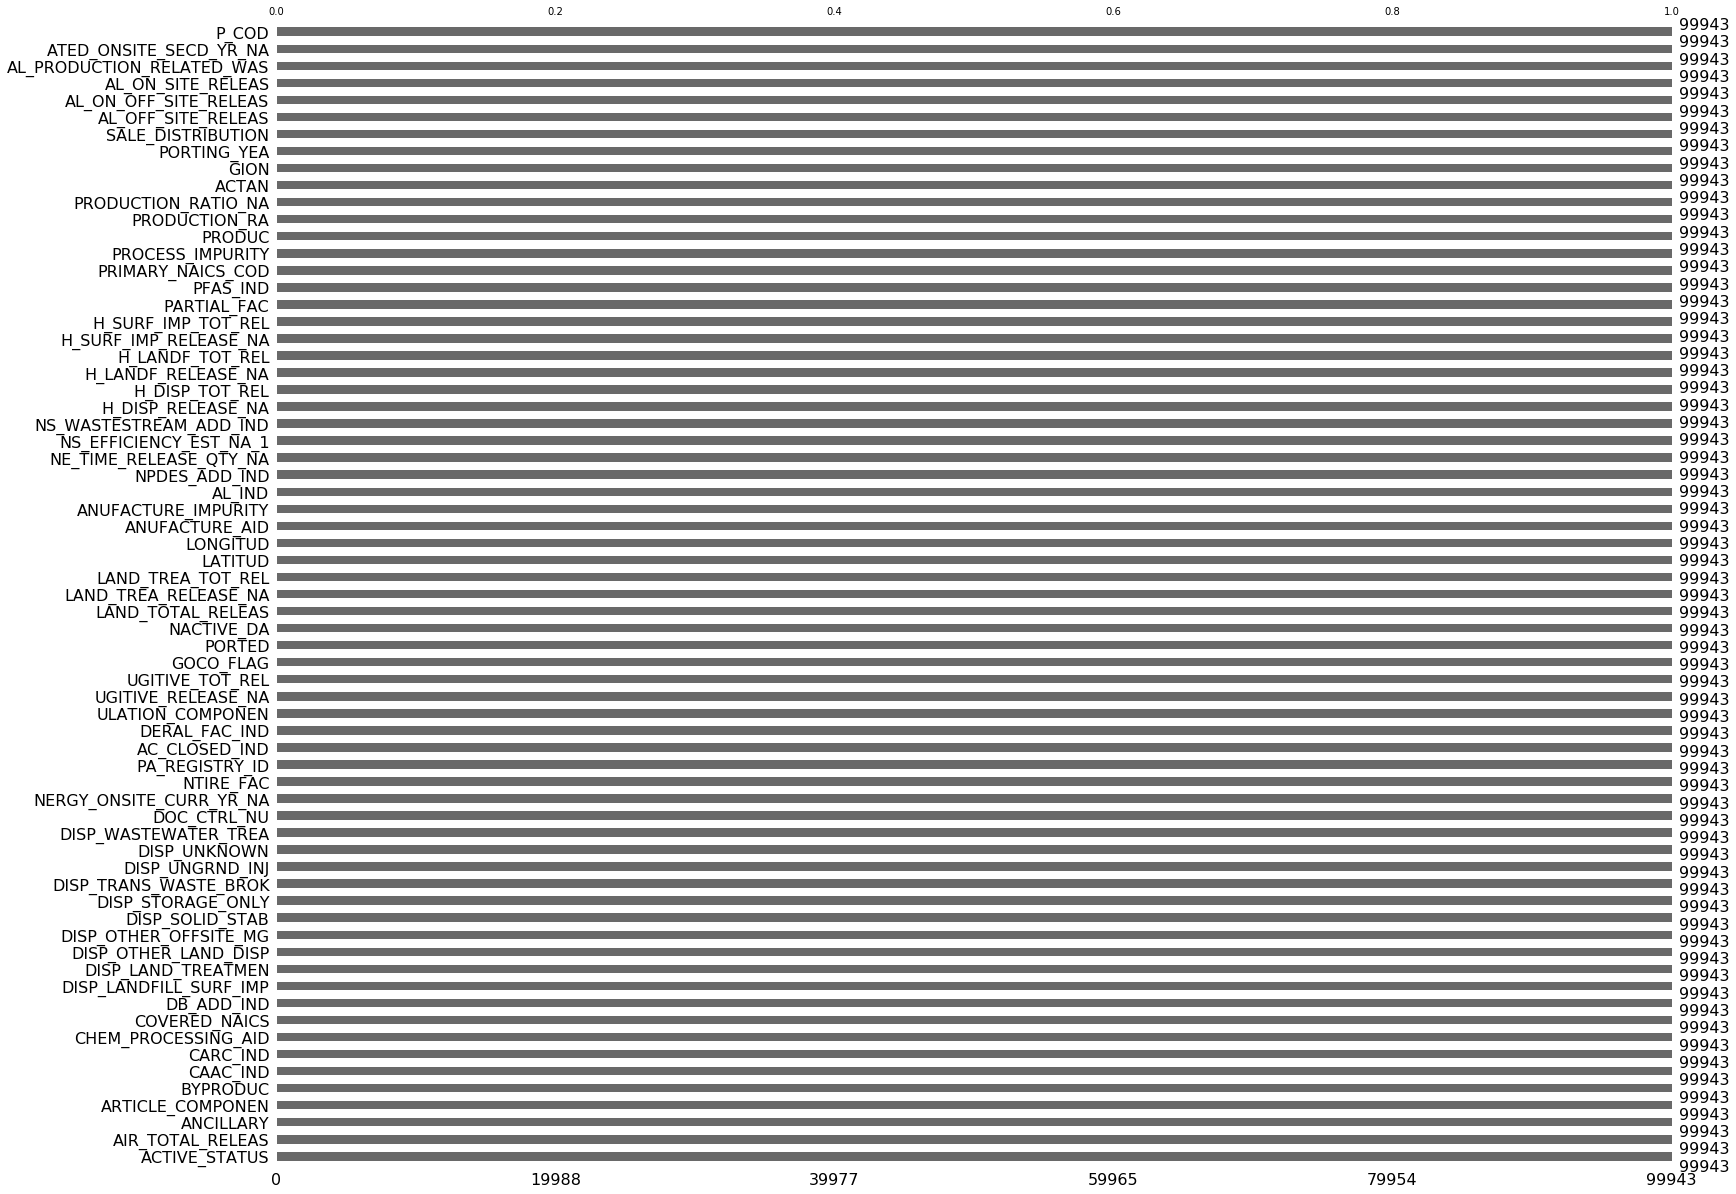

In [14]:
msno.bar(df)

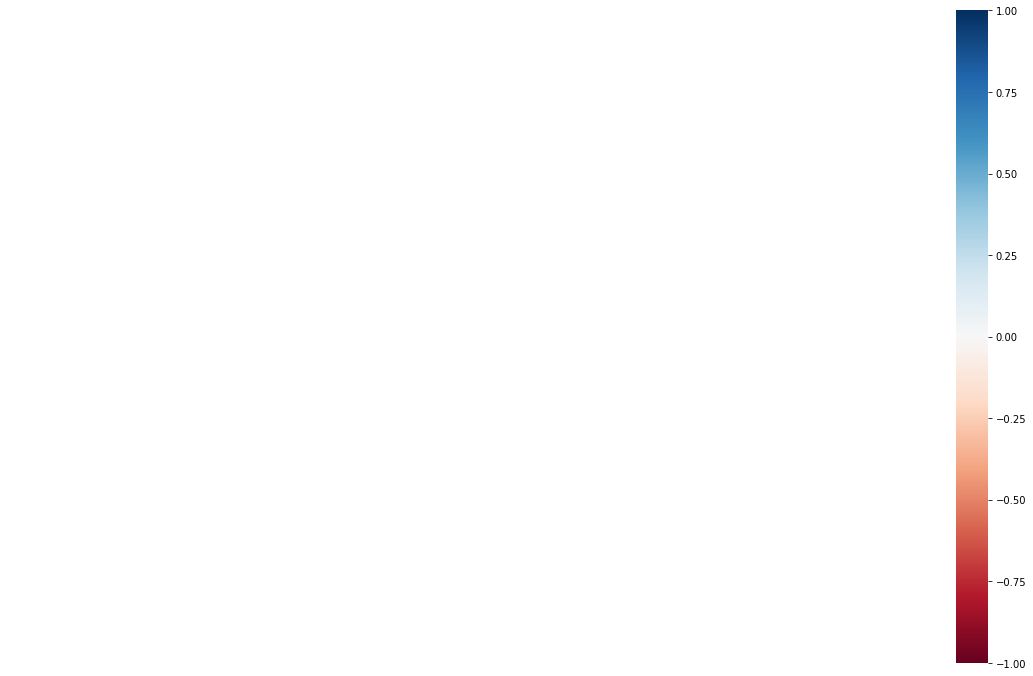

In [15]:
msno.heatmap(df)

#Balance Target Column

We will be predicting which toxic releases are carcinogenic. The target class is a bit imbalanced. With roughly 73% non-carcinogenic releases and roughly 27% carcinogenic releases.

In [16]:
df['CARC_IND'].value_counts()

0.0     73201
1.0     26741
42.0        1
Name: CARC_IND, dtype: int64

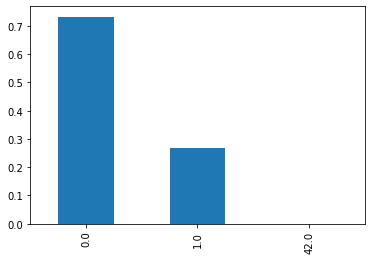

In [17]:
df['CARC_IND'].value_counts(normalize=True).plot(kind='bar')

In [18]:
df_minority = df[df['CARC_IND']==1]
df_majority = df[df['CARC_IND']==0]

To better proceed with a classification model execution, we will resample our target to randomly select only 26741 non-carcinogenic rows. This will balance our data.

In [19]:
#model_rfrs as roughly 70 misrepresented variables(which are from the majority class), 
#so I want to attempt to change random_state = 42 
#My goal is to increase my TP, Precision and Recall.

maj_class = resample(df_majority, 
                                 replace=True,     
                                 n_samples=26741,    
                                 random_state=42)
#After a slight improvement with random_state = 42, I now want to reduce the 
#minority class to represent the same 

In [20]:
df=pd.concat([df_minority,maj_class])

In [21]:
df['CARC_IND']

0        1.0
4        1.0
6        1.0
8        1.0
10       1.0
        ... 
68400    0.0
82251    0.0
65426    0.0
72230    0.0
69274    0.0
Name: CARC_IND, Length: 53482, dtype: float64

#Create the feature matrix and target array

In [22]:
target = 'CARC_IND'

y = df[target]
X = df.drop(columns=target)

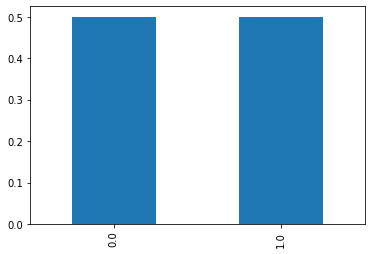

In [23]:
y.value_counts(normalize=True).plot(kind='bar')

#Create a train/test split

Choosing to do a random train/test split, because I am assuming that data from ealier years will reflect higher toxic outputs. 

In [72]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.4, random_state=42)

assert len(X_train) + len(X_val) == len(X)

#Establish the Baseline Accuracy

In [73]:
baseline_acc = y_train.value_counts(normalize=True).max()
print('Baseline accuracy:', baseline_acc)

Baseline accuracy: 0.5010751347813892


with filna(42)
Baseline accuracy: 0.5010751347813892

#Build Models

- `RandomForestClassifier`
- `XGBClassifier`

In [26]:
model_rf = make_pipeline(
    OrdinalEncoder(cols=[],mapping=[]),
    SimpleImputer(strategy='median'),
    StandardScaler(),
    RandomForestClassifier(random_state=42, n_jobs=-1,bootstrap=True,max_depth=30,
                           max_features=0.9507143064099162,n_estimators=100, criterion='gini',
                           min_samples_split=2, min_samples_leaf=1,
                           min_weight_fraction_leaf=0.0, max_leaf_nodes=None, 
                           min_impurity_decrease=0.0, 
                           oob_score=False, verbose=0, warm_start=False, 
                           class_weight=None, ccp_alpha=0.0, max_samples=None)
)
model_rf.fit(X_train, y_train)

Pipeline(steps=[('ordinalencoder', OrdinalEncoder(cols=[], mapping=[])),
                ('simpleimputer', SimpleImputer(strategy='median')),
                ('standardscaler', StandardScaler()),
                ('randomforestclassifier',
                 RandomForestClassifier(max_depth=30,
                                        max_features=0.9507143064099162,
                                        n_jobs=-1, random_state=42))])

In [27]:
print('model_rf accuracy score for training:', accuracy_score(y_train, model_rf.predict(X_train)))
print('model_rf accuracy score for val:', accuracy_score(y_val, model_rf.predict(X_val)))

model_rf accuracy score for training: 0.998971610209106
model_rf accuracy score for val: 0.7887159351189641


####**SCORES BEFORE RESAMPLING CORRECTION**
model_rf accuracy score for training: 0.9853532363115086

model_rf accuracy score for val: 0.7893703547889497

####**BEFORE SHAPLEY DROPS**

model_rf accuracy score for training: 0.999221765658075
model_rf accuracy score for val: 0.7918942895830415

In [28]:
model_xgb = make_pipeline(
    OrdinalEncoder(cols=[], drop_invariant=False, handle_missing='value',
                   handle_unknown='value',mapping=[],return_df=True,
                   verbose=0),
    StandardScaler(),
    SimpleImputer(strategy='median'),
    GradientBoostingClassifier(ccp_alpha=0.0,criterion='friedman_mse',
                               init=None,learning_rate=0.1,loss='deviance',
                               max_depth=3,max_features=None,max_leaf_nodes=None,
                               min_impurity_decrease=0.0,
                               min_samples_leaf=1,min_samples_split=2,
                               min_weight_fraction_leaf=0.0,n_estimators=100,
                               random_state=None,subsample=1.0,tol=0.0001,
                               validation_fraction=0.1,
                               verbose=0,warm_start=False)
)

model_xgb.fit(X_train, y_train);

In [29]:
print('model_xgb accuracy for training:', accuracy_score(y_train, model_xgb.predict(X_train)))
print('model_xgb accuracy for val:', accuracy_score(y_val, model_xgb.predict(X_val)))

model_xgb accuracy for training: 0.7357349870672193
model_xgb accuracy for val: 0.7277146730238864


#**Tune Models**

###**Crossvalidate both models**

In [30]:
cv_scores_rf = cross_val_score(model_rf, X, y, cv=5,n_jobs=-1)

In [31]:
cv_scores_xgb = cross_val_score(model_xgb, X, y, cv=5,n_jobs=-1)

####**Retrieve `RandomForestClassifier` Mean CV accuracy score and STD CV accuracy score**

In [32]:
print('CV score RandomForestClassifier')
print(cv_scores_rf)
print('Mean CV accuracy score:', cv_scores_rf.mean())
print('STD CV accuracy score:', cv_scores_rf.std())

CV score RandomForestClassifier
[0.80742264 0.80424418 0.80908751 0.80142109 0.81235976]
Mean CV accuracy score: 0.8069070368956156
STD CV accuracy score: 0.003793122725532621


####**Retrieve `XGBtClassifier` Mean CV accuracy score and STD CV accuracy score**

In [33]:
print('CV score GradientBoostingClassifier')
print(cv_scores_xgb)
print('Mean CV accuracy score:', cv_scores_xgb.mean())
print('STD CV accuracy score:', cv_scores_xgb.std())

CV score GradientBoostingClassifier
[0.72693278 0.72637188 0.73064697 0.72690726 0.73111444]
Mean CV accuracy score: 0.7283946652082113
STD CV accuracy score: 0.0020450512539624288


###Execute a Randomized Search to both our models

In [76]:
param_grid = {
    'simpleimputer__strategy': ['median'],
    'randomforestclassifier__max_depth': range(2, 40, 10),
    'randomforestclassifier__n_estimators': range(20, 125, 50)
}

model_rfrs = RandomizedSearchCV(
    clf,
    param_distributions = param_grid,
    n_jobs=-1,
    cv=5,
    verbose=1,
    n_iter = 7
)

model_rfrs.fit(X,y)

Fitting 5 folds for each of 7 candidates, totalling 35 fits


RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('ordinalencoder',
                                              OrdinalEncoder(cols=[],
                                                             mapping=[])),
                                             ('simpleimputer',
                                              SimpleImputer(strategy='median')),
                                             ('standardscaler',
                                              StandardScaler()),
                                             ('randomforestclassifier',
                                              RandomForestClassifier(max_depth=30,
                                                                     n_jobs=-1,
                                                                     random_state=42))]),
                   n_iter=7, n_jobs=-1,
                   param_distributions={'randomforestclassifier__max_depth': range(2, 40, 10),
                                 

In [35]:
gbc = GradientBoostingClassifier()
parameters = {
    "n_estimators":[5,50,250,500],
    "max_depth":[1,3,5,7,9],
    "learning_rate":[0.01,0.1,1,10,100]
}

xgb_gs = RandomizedSearchCV(gbc,parameters,cv=5)
xgb_gs.fit(X,y.values.ravel())

RandomizedSearchCV(cv=5, estimator=GradientBoostingClassifier(),
                   param_distributions={'learning_rate': [0.01, 0.1, 1, 10,
                                                          100],
                                        'max_depth': [1, 3, 5, 7, 9],
                                        'n_estimators': [5, 50, 250, 500]})

#####**Print out model's best parameters and best score**

In [78]:
print('RandomForestClassifier best_params:',model_rfrs.best_params_)
print('RandomForestClassifier best_score:',model_rfrs.best_score_)

RandomForestClassifier best_params: {'simpleimputer__strategy': 'median', 'randomforestclassifier__n_estimators': 120, 'randomforestclassifier__max_depth': 32}
RandomForestClassifier best_score: 0.8055234172213195


####**Before hyperparameter tweaking...**
RandomForestClassifier best_score: 0.797618622692479
####**Take two**
RandomForestClassifier best_score: 0.7996155511699883


In [37]:
model_be = model_rfrs.best_estimator_
model_be

Pipeline(steps=[('ordinalencoder', OrdinalEncoder(cols=[], mapping=[])),
                ('simpleimputer', SimpleImputer(strategy='median')),
                ('standardscaler', StandardScaler()),
                ('randomforestclassifier',
                 RandomForestClassifier(max_depth=32, n_estimators=70,
                                        n_jobs=-1, random_state=42))])

In [38]:
print('GradientBoostingClassifier best_params:',xgb_gs.best_params_)
print('GradientBoostingClassifier best_score:',xgb_gs.best_score_)

GradientBoostingClassifier best_params: {'n_estimators': 500, 'max_depth': 5, 'learning_rate': 1}
GradientBoostingClassifier best_score: 0.7704087271268851


#####**Confusion Matrix**

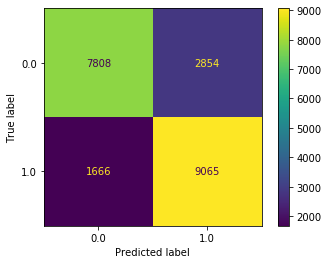

In [39]:
plot_confusion_matrix(
    model_rf,
    X_val,
    y_val,
    values_format = '.0f',
    
    
)

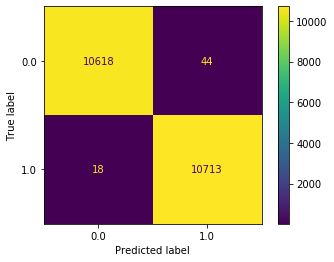

In [40]:
plot_confusion_matrix(
    model_rfrs,
    X_val,
    y_val,
    values_format = '.0f',
    
    
)
#appears to be the most accurate model

####**Model_rfrs before resampling correction**
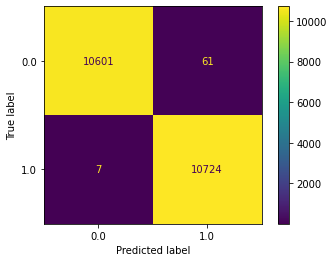

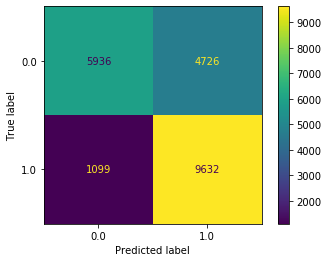

In [41]:
plot_confusion_matrix(
    model_xgb,
    X_val,
    y_val,
    values_format = '.0f',
    
    
)

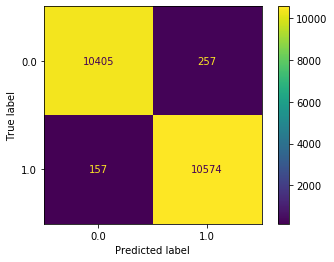

In [42]:
plot_confusion_matrix(
    xgb_gs,
    X_val,
    y_val,
    values_format = '.0f',
    
    
)

#####**Best model's (model_rfrs) Classification Report** 

In [43]:
print(classification_report(y_val,
                      model_rfrs.predict(X_val),
                      target_names =['Non-carcinogenic','carcinogenic']))

                  precision    recall  f1-score   support

Non-carcinogenic       1.00      1.00      1.00     10662
    carcinogenic       1.00      1.00      1.00     10731

        accuracy                           1.00     21393
       macro avg       1.00      1.00      1.00     21393
    weighted avg       1.00      1.00      1.00     21393



#`RandomForestClassification` model's important features

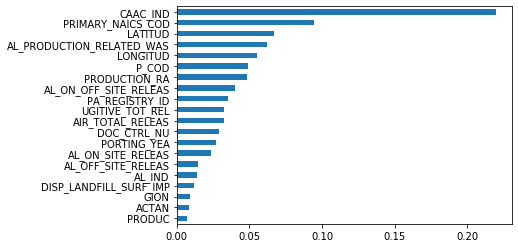

In [75]:
importances = model_rf.named_steps.randomforestclassifier.feature_importances_
features = X_train.columns
pd.Series(importances, index=features).sort_values().tail(20).plot(kind='barh');

####**Partial Dependency Interactive Plot**

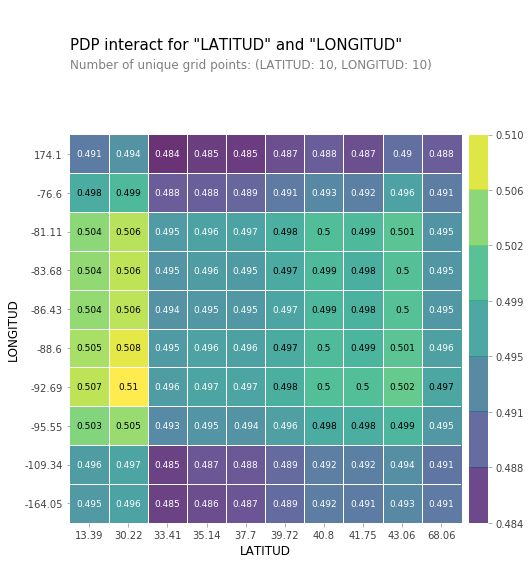

In [79]:
from pdpbox.pdp import pdp_interact, pdp_interact_plot
features = ['LATITUD',	'LONGITUD']

interaction = pdp_interact(
    model=model_rfrs, 
    dataset=X_val, 
    model_features=X_val.columns,
    features=features
)
pdp_interact_plot(interaction, plot_type='grid', feature_names=features);

####**Partial Dependecy Plot Isolate**

findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.


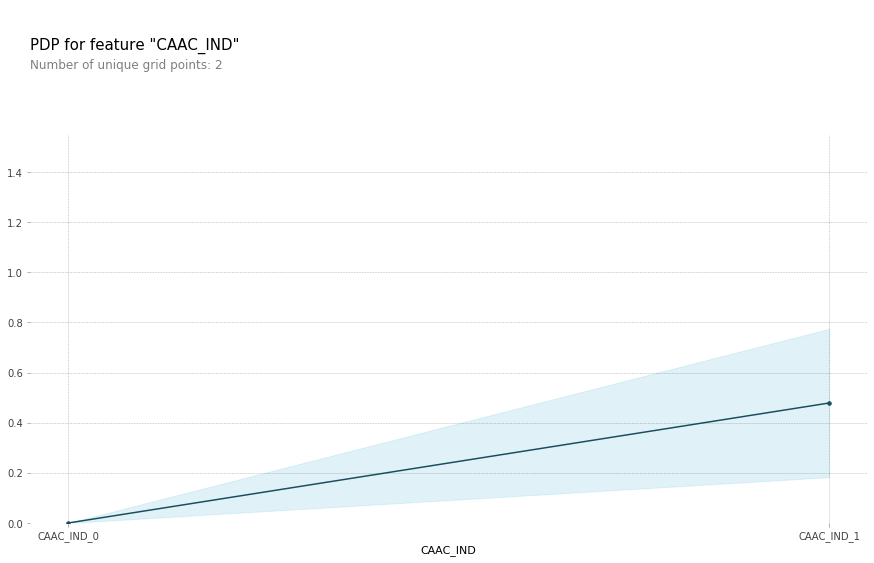

In [46]:
feature= 'CAAC_IND' #specify column feature

isolated = pdp_isolate(
    model=model_rfrs, 
    dataset=X_val, 
    model_features=X_val.columns, 
    feature= feature
)

#display visualization plot
pdp_plot(isolated, feature_name=feature);

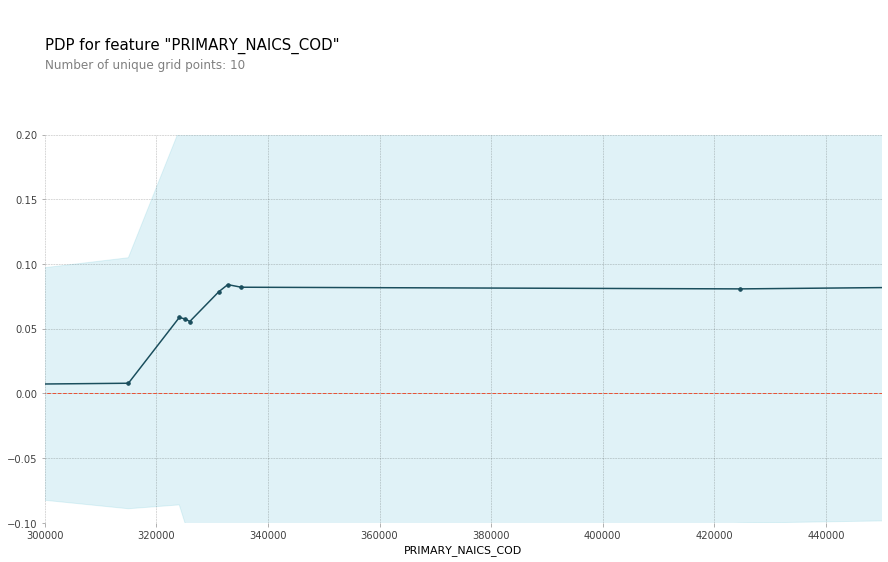

In [47]:
feature= 'PRIMARY_NAICS_COD' #specify column feature

isolated = pdp_isolate(
    model=model_rfrs, 
    dataset=X_val, 
    model_features=X_val.columns, 
    feature= feature
)

#set pdp_plot to fig, axes
fig, axes = pdp_plot(isolated, feature_name=feature);

#set lower and upper y limits
plt.ylim(-0.1,0.2)

#set the lower and upper X limits
plt.xlim(300000,450000)

#display visualization plot
plt.show()

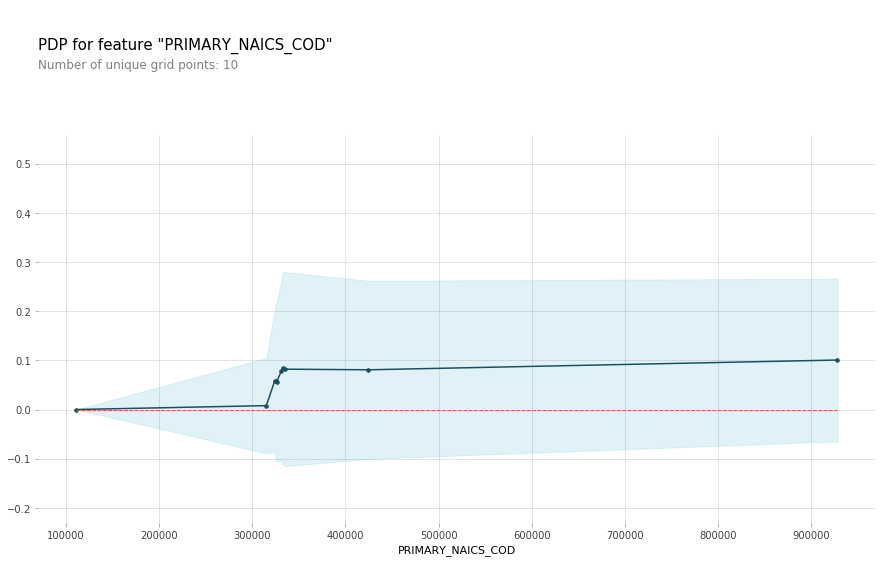

In [48]:
pdp_plot(isolated, feature_name=feature); #zoomed out

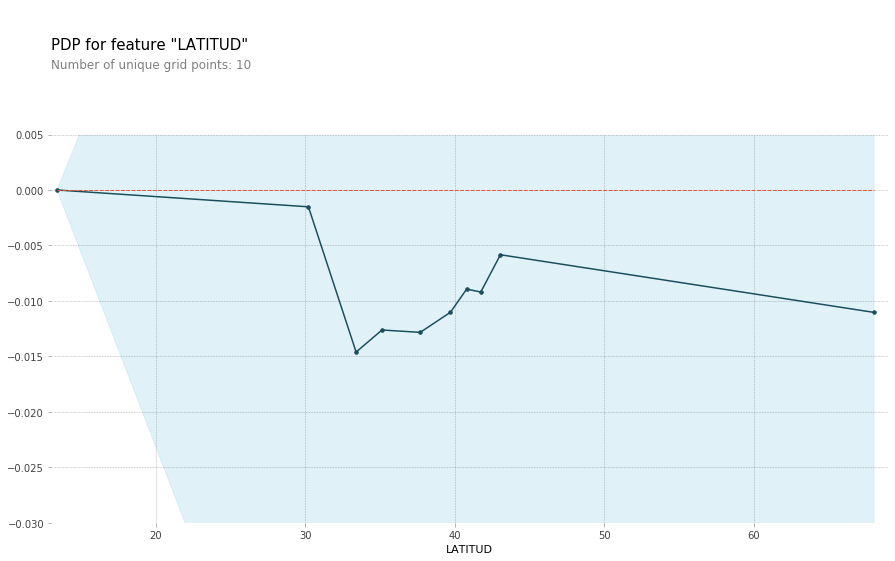

In [49]:
feature='LATITUD' #specify column feature

isolated = pdp_isolate(
    model=model_rfrs, 
    dataset=X_val, 
    model_features=X_val.columns, 
    feature= feature
)

#set pdp_plot to fig, axes
fig, axes = pdp_plot(isolated, feature_name=feature);

#set lower and upper y limits
plt.ylim(-0.03,0.005)

#set the lower and upper X limits
plt.xlim(13,69)

#display visualization plot
plt.show()

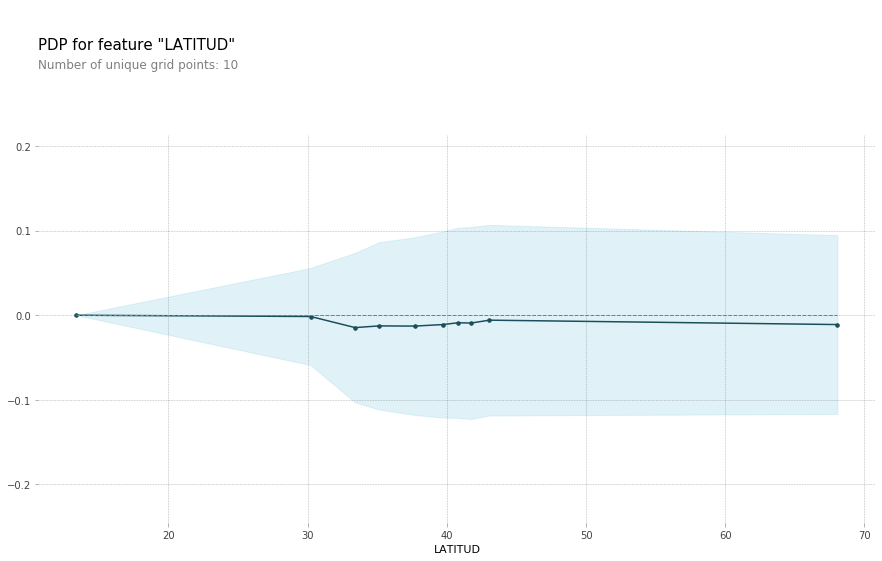

In [50]:
pdp_plot(isolated, feature_name=feature); #zoomed out

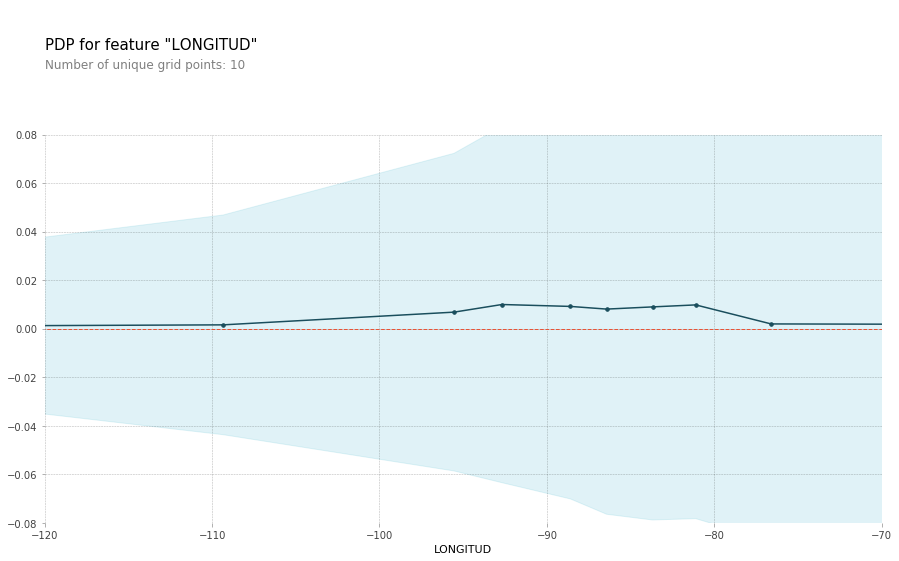

In [51]:
feature='LONGITUD' #specify column feature

feature = 'LONGITUD'

isolated = pdp_isolate(
    model=model_rfrs, 
    dataset=X_val, 
    model_features=X_val.columns, 
    feature=feature
)

#set pdp_plot to fig, axes
fig, axes = pdp_plot(isolated, feature_name=feature);

#set lower and upper y limits
plt.ylim(-0.08,0.08)

#set the lower and upper X limits
plt.xlim(-120,-70)

#display visualization plot
plt.show()

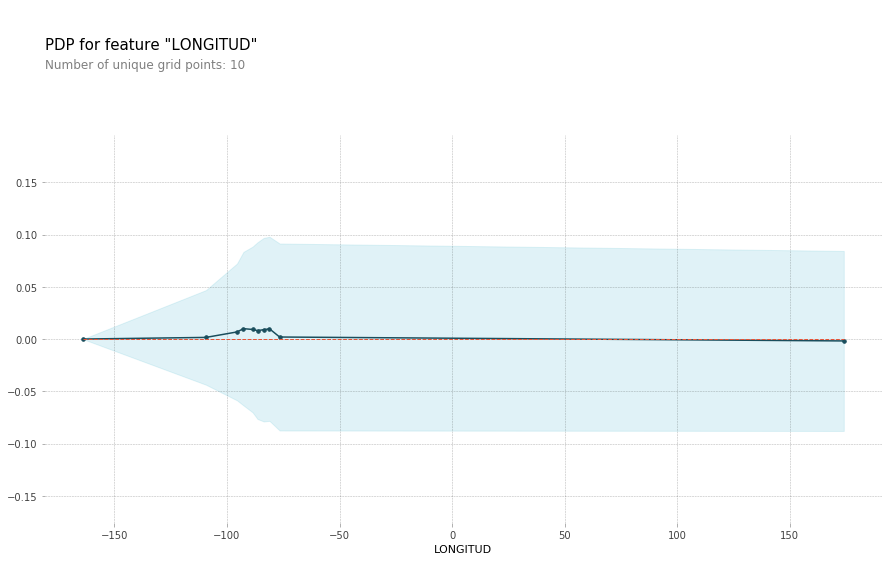

In [52]:
pdp_plot(isolated, feature_name=feature); #zoomed out

####**Construct Shapley**

In [53]:
# Get an individual observation to explain.

row = X_val.iloc[[111]] # Dataframe with a single row (double brackets keeps it a dataframe)
row

,ACTIVE_STATUS,AIR_TOTAL_RELEAS,ANCILLARY,ARTICLE_COMPONEN,BYPRODUC,CAAC_IND,CHEM_PROCESSING_AID,COVERED_NAICS,DB_ADD_IND,DISP_LANDFILL_SURF_IMP,DISP_LAND_TREATMEN,DISP_OTHER_LAND_DISP,DISP_OTHER_OFFSITE_MG,DISP_SOLID_STAB,DISP_STORAGE_ONLY,DISP_TRANS_WASTE_BROK,DISP_UNGRND_INJ,DISP_UNKNOWN,DISP_WASTEWATER_TREA,DOC_CTRL_NU,NERGY_ONSITE_CURR_YR_NA,NTIRE_FAC,PA_REGISTRY_ID,AC_CLOSED_IND,DERAL_FAC_IND,ULATION_COMPONEN,UGITIVE_RELEASE_NA,UGITIVE_TOT_REL,GOCO_FLAG,PORTED,NACTIVE_DA,LAND_TOTAL_RELEAS,LAND_TREA_RELEASE_NA,LAND_TREA_TOT_REL,LATITUD,LONGITUD,ANUFACTURE_AID,ANUFACTURE_IMPURITY,AL_IND,NPDES_ADD_IND,NE_TIME_RELEASE_QTY_NA,NS_EFFICIENCY_EST_NA_1,NS_WASTESTREAM_ADD_IND,H_DISP_RELEASE_NA,H_DISP_TOT_REL,H_LANDF_RELEASE_NA,H_LANDF_TOT_REL,H_SURF_IMP_RELEASE_NA,H_SURF_IMP_TOT_REL,PARTIAL_FAC,PFAS_IND,PRIMARY_NAICS_COD,PROCESS_IMPURITY,PRODUC,PRODUCTION_RA,PRODUCTION_RATIO_NA,ACTAN,GION,PORTING_YEA,SALE_DISTRIBUTION,AL_OFF_SITE_RELEAS,AL_ON_OFF_SITE_RELEAS,AL_ON_SITE_RELEAS,AL_PRODUCTION_RELATED_WAS,ATED_ONSITE_SECD_YR_NA,P_COD
94917,1,0.3381,1.0,0.0,0.0,1.0,1.0,1.0,0.0,14.3156,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.316220e+12,1.0,1.0,1.100000e+11,0.0,0.0,0.0,0.0,0.1518,0.0,0.0,9999.0,0.0,1.0,0.0,32.11087,-110.95356,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,336411.0,0.0,0.0,1.12,0.0,0.0,9.0,2016.0,0.0,14.3156,14.6537,0.3381,14.6537,1.0,85756.0


In [54]:
y_val.iloc[[111]]

94917    1.0
Name: CARC_IND, dtype: float64

In [55]:
from scipy.stats import randint, uniform

param_distributions = { 
    'n_estimators': randint(50, 500), 
    'max_depth': [5, 10, 15, 20, None], 
    'max_features': uniform(0, 1), 
}

search = RandomizedSearchCV(
    RandomForestClassifier(random_state=42), 
    param_distributions=param_distributions, 
    n_iter=3, 
    cv=5, 
    scoring='neg_mean_absolute_error', 
    verbose=1, 
    return_train_score=True, 
    n_jobs=-1, 
    random_state=42
)

search.fit(X, y);

Fitting 5 folds for each of 3 candidates, totalling 15 fits


In [56]:
print('Best hyperparameters', search.best_params_)
print('Cross-validation MAE', -search.best_score_)
model = search.best_estimator_

Best hyperparameters {'max_depth': None, 'max_features': 0.596850157946487, 'n_estimators': 171}
Cross-validation MAE 0.18838116769050578


In [57]:
i = len(row)

explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(row)

shap.initjs()
shap.force_plot(
    base_value=explainer.expected_value[0], #In v0.20 force_plot now requires the base value as the first parameter! 
    shap_values=shap_values[i], #The shap_values has a multi output so make variable represent len(row)
    features=row
)